# Introduction

This notebook compares protemics data to model predictions

Note that the flux measurements in this notebook were measured and published in:
~~~
Thompson, R.A., Layton, D.S., Guss, A.M., Olson, D.G., Lynd, L.R., Trinh, C.T., 2015. Elucidating Central Metabolic Redox Obstacles Hindering Ethanol Production in Clostridium thermocellum, Metab Eng, 32: 207-21
~~~
The proteomics was measured from the same experiments in the case of the mutant, and a similar experiment for WT. See this manuscript for more details

# Setup

In [1]:
import sys
sys.path.append('../../')

import csv
from tools.conf_model import *
import cobra as cb
import settings

import pandas as pd
from settings import get_gene_map
from scipy.stats.mstats import gmean
from statistics import mean
from math import log2

import seaborn as sns
# plot configuration
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


# Model
icbi = cb.io.load_json_model(os.path.join(settings.PROJECT_ROOT,'iCBI', 'iCBI655_cellobiose_batch.json'))

# Proteomics
1. General statistics:
    - genes in model, genes in proteomics, overlap
    - n. of overlapping genes which appear in teh same gpr
2. How to compute some FC value for a gpr? Just take average? Maybe geometric average?

In [2]:
pt = pd.read_csv('../../datasets/protein/raw-data/1/wt_v_hydg-ech.csv')
gm = get_gene_map()
pt['protein_id'] = pt['protein_id'].map(gm)
gene_fc = pt.set_index('protein_id').to_dict()['fc_1_v_3']

In [3]:
genes_protein = set(pt['protein_id'])
genes_model = set ([g.id for g in icbi.genes])
genes_common = genes_protein.intersection(genes_model)
print('Genes protein\t', len(genes_protein))
print('Genes model\t', len(genes_model)- 1)
print('overlap\t', len(genes_common))
print('Genes protein - overlap\t', len(genes_protein)- len(genes_common))
print('Genes model - overlap\t', len(genes_model)- 1 - len(genes_common))

# Ven diagram:

Genes protein	 1001
Genes model	 665
overlap	 394
Genes protein - overlap	 607
Genes model - overlap	 271


In [4]:
# Create the following table:
# Reaction id, associated genes(measured FC), geometric FC

# Find out reactions associated with measured proteins
rxns = []
for g_id in list(genes_common):
    gene = icbi.genes.get_by_id(g_id)
    for rxn in gene.reactions:
        rxns.append(rxn.id)
rxns = list(set(rxns))
print('Reactions captured by proteomic genes:', len(rxns))

rows = []
for rxn_id in rxns:

    rxn = icbi.reactions.get_by_id(rxn_id)
    gene_ids = [g.id for g in rxn.genes]
    col2 = ''
    vals = []
    for gene_id in gene_ids:
        if col2:
            col2+=', '
        if gene_id in gene_fc:
            vals.append(gene_fc[gene_id])
            col2+='{}({:.2f})'.format(gene_id,gene_fc[gene_id])
        else:
            col2+='{}({})'.format(gene_id,'n.d.')

    vals = [gene_fc[gene_id] for gene_id in gene_ids if gene_id in gene_fc]
    
    row = {}
    row['rxn_id'] = rxn.id
    row['genes(FC)'] = col2
    row['mean_FC'] = mean(vals)
    rows.append(row)

prot = pd.DataFrame(rows)
prot = prot.set_index('rxn_id')
prot.head()

Reactions captured by proteomic genes: 510


,genes(FC),mean_FC
rxn_id,,
GTPCI,CLO1313_RS14615(-0.16),-0.164925
MTHFC,CLO1313_RS05690(1.24),1.240310
PRATPP,CLO1313_RS02170(0.22),0.220740
IPPMIa,"CLO1313_RS14655(0.22), CLO1313_RS14650(0.16)",0.186919
CHRS,CLO1313_RS07535(-0.42),-0.415455


# Flux
Constrain boundaries to measured fluxes and calculate intracellular fluxes with pFBA

In [5]:
# Dataset
ds = pd.read_csv(settings.EXTRACELLULAR_FLUX_DATA)
ds.set_index('index', inplace=True)
ds.head(4)

,Strain,deleted_genes,Medium,Reference,Reactor,Notes,cellb,cellb_std,glceq,glceq_std,...,phe__L,phe__L_std,cell3,cell3_std,cell4,cell4_std,cell5,cell5_std,cell6,cell6_std
index,,,,,,,,,,,,,,,,,,,,,
0,WT,NaN,MTC-cellb,PMID26497628,Batch,NaN,-3.58,0.16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hydG,Clo1313_1571,MTC-cellb,PMID26497628,Batch,NaN,-3.43,0.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"hydG, ech","Clo1313_1571, Clo1313_0570-0575",MTC-cellb,PMID26497628,Batch,NaN,-4.33,0.62,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"hydG, pta-ack","Clo1313_1571, Clo1313_1185-1186",MTC-cellb,PMID26497628,Batch,NaN,-2.42,0.05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Model updates
The presence of two transporters for pnto is an error, the non-symport version will be removed since it has less metadata, this changes will be applied to a different branch of the model named "current"

In [6]:
print(icbi.reactions.PNTOt2r)
print(icbi.reactions.PNTOt2r2)
icbi.reactions.PNTOt2r2.knock_out()

PNTOt2r: h_e + pnto__R_e <=> h_c + pnto__R_c
PNTOt2r2: pnto__R_e <=> pnto__R_c


## Setup model and data

In [7]:
mut_ko = {}
mut_ko[0] = [] #WT
## hydg
#mut_ko[1] = ['BIF','H2ASE_syn']
# hydg-ech
mut_ko[2] = ['BIF','H2ASE_syn', 'ECH'] # This mutant is infeasible with experimental data since small hydrogen secretion is measured

dsm = ds
dsm.loc[2,'h2'] = 0
dsm.loc[2,'h2_std'] = 0
dsm.to_csv('modified_flux_ds.csv')

In [8]:
def setup_model(model, index):
    set_experimental_data(model, dataset_index=index, constraint_mode='both',
                              reactor_type=dsm.loc[index,'Reactor'], secretion='all',
                             flux_dataset_path='./modified_flux_ds.csv')
        # Gene parsing seems b0rked so specific reaction deletions are specified here:
    [model.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko[index]]

    if 'cellb' in ds.loc[index, 'Medium']:
        set_bof(model, 'BIOMASS_CELLOBIOSE') # Note that set_bof resets the bounds of the biomass function to (0,1000)
    elif 'avcell' in ds.loc[index, 'Medium']:
        set_bof(model, 'BIOMASS_CELLULOSE')
    else:
        raise Exception('Medium cannot be identified for iSG. Index {} \t Medium {}'.format(index, ds.loc[index, 'Medium']))  

def calc_pfba(index):
    with icbi as model:
        setup_model(model, index)
        try:
            fba_solution = model.optimize()
            pfba_solution = cb.flux_analysis.pfba(model)
        except AttributeError as e:
            #raise e
            print("Infeasible solution, index:",index)
            return None
        
        return pfba_solution;

# Divide flux distribution by carbon uptake, currently all cases use the same susbtrate
def normalize_fluxes(s):
    return s/abs(s['EX_cellb_e'])

def normalize_fva(fba_sol):
    sur = fva_sol.loc['EX_cellb_e',:]
    return fva_sol/abs(sur.mean())
    
# Note that loopless is slow!
def calc_fva(index):
    with icbi as model:
        setup_model(model, index)
    
        fva_sol = cb.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0, loopless=True)
        
        rd = {'minimum': '{}_min'.format(index), 'maximum': '{}_max'.format(index) }
        fva_sol = fva_sol.rename(rd, axis='columns')
        return fva_sol;

# Calculations

In [9]:
# Calculate pfba and fva
pfba_sols = pd.DataFrame(index=[rxn.id for rxn in icbi.reactions])
for index in [0,2]: # Only look at first cases
    pfba = calc_pfba(index)
    s = pfba.fluxes
    s.name = index
    s = normalize_fluxes(s)
    pfba_sols = pfba_sols.join(s)
    
    fva_sol = calc_fva(index)
    fva_sol_n = normalize_fva(fva_sol)
    pfba_sols = pfba_sols.join(fva_sol_n)
#pfba_sols_og = pfba_sols.copy()

In [10]:
pfba_sols['0_center'] = pfba_sols[['0_min','0_max']].mean('columns')
pfba_sols['2_center'] = pfba_sols[['2_min','2_max']].mean('columns')

In [11]:
# Calc stdev and FC 
# Note FC calculation is done as with the proteomics data
# apply "flooring" to avoid artificts such as 0 to 0.000001 being an inf fold change
# Additionally, to put fluxes in a > 0 scale the minimum value is added to all fluxes
floor_val = 0.0001
def floor_flux(flux_value):
    if flux_value < floor_val:
        return floor_val
    return flux_value

def floor_flux_d(flux_value):
    if (flux_value <= 0) and (flux_value > -floor_val):
        return -floor_val
    if (flux_value >= 0) and (flux_value < floor_val):
        return floor_val
    return flux_value

def get_flux(value):
    return log2(floor_flux(abs(value)))

def calc_fc(row, mut_id, wt_id):
    return get_flux(row[mut_id]) - get_flux(row[wt_id])


pfba_sols['pfba_FC'] = pfba_sols.apply(lambda row: calc_fc(row,2,0), axis=1)
#pfba_sols['min_FC'] = pfba_sols.apply(lambda row: calc_fc(row,'2_min','0_min'), axis=1)
#pfba_sols['max_FC'] = pfba_sols.apply(lambda row: calc_fc(row,'2_max','0_max'), axis=1)
pfba_sols['center_FC'] = pfba_sols.apply(lambda row: calc_fc(row,'2_center','0_center'), axis=1)

pfba_sols = pfba_sols.sort_values('pfba_FC', ascending=False)

pfba_sols.head()

,0,0_min,0_max,2,2_min,2_max,0_center,2_center,pfba_FC,center_FC
ALCD23xi,0.0,0.0,0.744413,0.49031,0.000000e+00,1.327945,0.372207,0.663972,12.259477,0.835019
IBUTCOARx,0.0,0.0,0.744413,0.49031,0.000000e+00,1.327945,0.372207,0.663972,12.259477,0.835019
IBUTOHt,0.0,0.0,0.744413,0.49031,0.000000e+00,1.327945,0.372207,0.663972,12.259477,0.835019
VOR2b,0.0,0.0,0.744413,0.49031,-2.050836e-13,1.327945,0.372207,0.663972,12.259477,0.835019
EX_ibutoh_e,0.0,0.0,0.744413,0.49031,0.000000e+00,1.327945,0.372207,0.663972,12.259477,0.835019


# Combined analysis 
Expected cases:
- Both FC agree: More confidence
- FC protein is greater than FC simulation: Enzyme might have low efficency
- FC protein is lower than FC simulation: Enzyme might be highly effient

In [12]:
# Make sure to only join common elements!
cdf = prot.join(pfba_sols)
#cdf = pd.merge(pfba_sols, prot, on='index')
assert(len(cdf.index) == len(prot.index))
#cdf = cdf.replace([np.inf, -np.inf], max(prot.mean_FC.abs())) # Replace inf from pfba by the max FC observed in proteomics
#cdf['FC_dist'] = abs(cdf['mean_FC'] -cdf['pfba_FC'])
#cdf = cdf.sort_values('FC_dist', ascending=True)
cdf = cdf.sort_values('mean_FC', ascending=False)
cdf['reaction'] = cdf.index.map({rxn.id: rxn.reaction for rxn in icbi.reactions})
cdf['name'] = cdf.index.map({rxn.id: rxn.name for rxn in icbi.reactions})

#cdfc = cdf[['genes(FC)','mean_FC', 'pfba_FC','min_FC', 'max_FC', 'center_FC']]
cdfc = cdf[['name','reaction', 'genes(FC)','mean_FC', 'pfba_FC', 'center_FC']]
cdfc = cdfc.round(1)

# Consistency:
def is_consistent(row):
    if (row['mean_FC'] > 0) and ((row['pfba_FC'] > 0) or (row['pfba_FC'] > 0)):
        return True
    if (row['mean_FC'] < 0) and ((row['pfba_FC'] < 0) or (row['pfba_FC'] < 0)):
        return True
    return False

cdfc['is_consistent'] = cdfc.apply(is_consistent, axis=1)

cdfc.head(20)

,name,reaction,genes(FC),mean_FC,pfba_FC,center_FC,is_consistent
rxn_id,,,,,,,
3HAD60,3-hydroxyacyl-[acyl-carrier-protein] dehydrata...,3hhexACP_c <=> h2o_c + thex2eACP_c,CLO1313_RS01090(9.11),9.1,-0.3,-0.1,False
3HAD120,3-hydroxyacyl-[acyl-carrier-protein] dehydrata...,3hddecACP_c <=> h2o_c + tddec2eACP_c,CLO1313_RS01090(9.11),9.1,-0.3,-0.1,False
3HAD100,3-hydroxyacyl-[acyl-carrier-protein] dehydrata...,3hdecACP_c <=> h2o_c + tdec2eACP_c,CLO1313_RS01090(9.11),9.1,-0.3,-0.1,False
3HAD40_1,3-hydroxyacyl-[acyl-carrier-protein] dehydrata...,3hbutACP_c <=> but2eACP_c + h2o_c,CLO1313_RS01090(9.11),9.1,-0.3,-0.1,False
3HAD80,3-hydroxyacyl-[acyl-carrier-protein] dehydrata...,3hoctACP_c + h_c <=> h2o_c + toct2eACP_c,CLO1313_RS01090(9.11),9.1,-0.3,-0.1,False
3HAD140,3-hydroxyacyl-[acyl-carrier-protein] dehydrata...,3hmrsACP_c <=> h2o_c + tmrs2eACP_c,CLO1313_RS01090(9.11),9.1,-0.3,-0.1,False
3HAD160,3-hydroxyacyl-[acyl-carrier-protein] dehydrata...,3hpalmACP_c <=> h2o_c + tpalm2eACP_c,CLO1313_RS01090(9.11),9.1,-0.3,-0.1,False
3HAD180,3-hydroxyacyl-[acyl-carrier-protein] dehydrata...,3hoctaACP_c <=> h2o_c + toctd2eACP_c,CLO1313_RS01090(9.11),9.1,-0.3,-0.1,False
CHORM,Chorismate mutase,chor_c --> pphn_c,"CLO1313_RS07640(8.50), CLO1313_RS04470(n.d.)",8.5,-0.3,0.7,False


In [13]:
# Now filter by consistency
tbl = cdfc[cdfc['is_consistent'] == True]
tbl = tbl.drop('is_consistent',1)
tbl

,name,reaction,genes(FC),mean_FC,pfba_FC,center_FC
rxn_id,,,,,,
MDH,Malate dehydrogenase,mal__L_c + nad_c <=> h_c + nadh_c + oaa_c,CLO1313_RS09495(1.36),1.4,0.2,0.1
PEPCK_re,Phosphoenolpyruvate carboxykinase (GTP),co2_c + gdp_c + pep_c --> gtp_c + oaa_c,CLO1313_RS02095(0.90),0.9,0.1,0.1
VOR2b,3-methyl-2-oxobutanoate dehydrogenase (ferredo...,3mob_c + coa_c + 2.0 fdxo_42_c --> co2_c + 2.0...,CLO1313_RS06860(0.87),0.9,12.3,0.8
PFL,Pyruvate formate lyase,coa_c + pyr_c --> accoa_c + for_c,"CLO1313_RS08680(0.70), CLO1313_RS09160(-0.16),...",0.5,0.2,0.8
FRNDPR2r,Ferredoxin : nadp reductase (NFN),2.0 fdxr_42_c + h_c + nadh_c + 2.0 nadp_c <=> ...,"CLO1313_RS09340(0.18), CLO1313_RS09345(0.34)",0.3,0.2,2.3
ALCD23xi,Aldehyde dehydrogenase isobutyl alcohol NAD,2mppal_c + h_c + nadh_c --> ibutoh_c + nad_c,CLO1313_RS09095(0.11),0.1,12.3,0.8
ACALD,Acetaldehyde dehydrogenase (acetylating),accoa_c + h_c + nadh_c --> acald_c + coa_c + n...,"CLO1313_RS14795(n.d.), CLO1313_RS09095(0.11)",0.1,0.8,1.1
IBUTCOARx,Isobutyryl-CoA reductase (NADH),h_c + ibcoa_c + nadh_c --> 2mppal_c + coa_c + ...,"CLO1313_RS14795(n.d.), CLO1313_RS09095(0.11)",0.1,12.3,0.8
ALCD2x,Alcohol dehydrogenase (ethanol),acald_c + h_c + nadh_c --> etoh_c + nad_c,CLO1313_RS09095(0.11),0.1,0.8,0.6


In [14]:
# Write tables:
# all
tbl.to_csv('all_descend.tsv', sep='\t')
tbl = tbl.sort_values('mean_FC', ascending=True)
tbl.to_csv('all_ascend.tsv', sep='\t')
# mean_FC for escher
tbl['mean_FC'].to_csv('mean_FC.csv')
# pfba_FC for escher
tbl['pfba_FC'].to_csv('pfba_FC.csv')

# Plots of consistent data


In [15]:
pc = tbl.corr()
pc

,mean_FC,pfba_FC,center_FC
mean_FC,1.000000,0.261606,0.088614
pfba_FC,0.261606,1.000000,0.435582
center_FC,0.088614,0.435582,1.000000


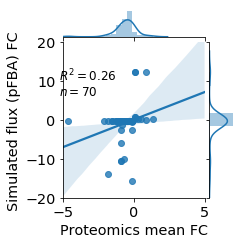

In [16]:
g = sns.jointplot("mean_FC", "pfba_FC", data=tbl, kind="reg", height=3.5,
                 xlim=(-5,5), ylim=(-20, 20))
#g.annotate(0,0,"hety")
g.fig.text(0.25,0.6, '$R^2={:.2f}$\n$n={}$'.format(pc.loc['mean_FC','pfba_FC'],tbl.shape[0]), ha='left', fontsize = 12);
g.set_axis_labels("Proteomics mean FC", 'Simulated flux (pFBA) FC')
plt.savefig('correlation_pfba.svg')

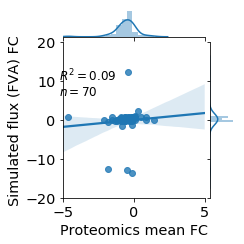

In [17]:
g = sns.jointplot("mean_FC", "center_FC", data=tbl, kind="reg", height=3.5,
                 xlim=(-5,5), ylim=(-20, 20))
#g.annotate(0,0,"hety")
g.fig.text(0.25,0.6, '$R^2={:.2f}$\n$n={}$'.format(pc.loc['mean_FC','center_FC'],tbl.shape[0]), ha='left', fontsize = 12);
g.set_axis_labels("Proteomics mean FC", 'Simulated flux (FVA) FC')
plt.savefig('correlation_fva.svg')

# Disagreements?
What fold changes are oppossite and could this be meaningful?

# Fate of nadph
After studying the data and the literature, an increase of nadph is very likely to be an important mechanism for this mutant (and C. therm in general to deal with redox stress). So let us use the simulations to further elucidate where this nadph could be oxidized.

- Let's focus on pathways that are changing between wild-type and mutant, since the hypthesis is based on a difference between these two. 
- Let's focus on pFBA for the sake of simplicity and since it provides a flux distribution (while FVA does not)

In [18]:
# Remember our simulated fluxes:
pfba_sols.head(2)

,0,0_min,0_max,2,2_min,2_max,0_center,2_center,pfba_FC,center_FC
ALCD23xi,0.0,0.0,0.744413,0.49031,0.0,1.327945,0.372207,0.663972,12.259477,0.835019
IBUTCOARx,0.0,0.0,0.744413,0.49031,0.0,1.327945,0.372207,0.663972,12.259477,0.835019


In [19]:
def is_nadph(rxn_id):
    rxn = icbi.reactions.get_by_id(rxn_id)
    for mets in rxn.metabolites:
        if mets.id in ['nadph_c', 'nadph_e']:
            return True
    return False
# Test
print(icbi.reactions.MDH.reaction, is_nadph('MDH'))
print(icbi.reactions.ME2.reaction, is_nadph('ME2'))

def is_exchange(rxn_id):
    return icbi.reactions.get_by_id(rxn_id) in icbi.exchanges

def is_exchange_or_nadph(rxn_id):
    return is_exchange(rxn_id) or is_nadph(rxn_id)


mal__L_c + nad_c <=> h_c + nadh_c + oaa_c False
mal__L_c + nadp_c --> co2_c + nadph_c + pyr_c True


In [20]:
minFC = 0
#fdf = pfba_sols.loc[(pfba_sols['pfba_FC'].abs() > minFC ) | (pfba_sols['center_FC'].abs() > minFC), :]
fdf = pfba_sols.loc[(pfba_sols['pfba_FC'].abs() > minFC ), [0,2, 'pfba_FC']]
fdf = fdf.loc[fdf.index.map(is_exchange_or_nadph),:]
fdf['formula'] = fdf.index.map(lambda x: icbi.reactions.get_by_id(x).reaction)
fdf['name'] = fdf.index.map(lambda x: icbi.reactions.get_by_id(x).name)
fdf = fdf[['name','formula',0,2,'pfba_FC']]
fdf = fdf.round(2)
fdf.rename({'name':'Reaction name', 'formula':'Reaction formula', '0':'W.T.', '2':'$\Delta$hydG-$\Delta$ech','pfba_FC':'Flux FC' }).to_csv('nadph_and_exch.tsv', sep='\t')

In [21]:
fdf.head()

,name,formula,0,2,pfba_FC
EX_ibutoh_e,Isobutyl alcohol exchange,ibutoh_e -->,0.00,0.49,12.26
KARA1,"Ketol-acid reductoisomerase (2,3-dihydroxy-3-m...",alac__S_c + h_c + nadph_c --> 23dhmb_c + nadp_c,0.22,0.59,1.42
EX_etoh_e,Ethanol exchange,etoh_e -->,1.09,1.88,0.78
EX_h2o_e,H2O exchange,h2o_e <=>,-0.38,0.50,0.42
EX_co2_e,CO2 exchange,co2_e -->,2.07,2.77,0.42


In [22]:
#Fva

minFC = 0
#fdf = pfba_sols.loc[(pfba_sols['pfba_FC'].abs() > minFC ) | (pfba_sols['center_FC'].abs() > minFC), :]
fdf = pfba_sols.loc[(pfba_sols['center_FC'].abs() > minFC ), ['0_min','0_max','2_min','2_max','center_FC']]
fdf = fdf.loc[fdf.index.map(is_exchange_or_nadph),:]
fdf['formula'] = fdf.index.map(lambda x: icbi.reactions.get_by_id(x).reaction)
fdf['name'] = fdf.index.map(lambda x: icbi.reactions.get_by_id(x).name)
fdf = fdf.round(2)
def combine_bounds(row, minid, maxid):
    return '{}/{}'.format(row[minid], row[maxid])
fdf['0_bounds'] = fdf.apply(lambda row: combine_bounds(row, '0_min', '0_max'), axis=1)
fdf['2_bounds'] = fdf.apply(lambda row: combine_bounds(row, '2_min', '2_max'), axis=1)
fdf = fdf[['name','formula','0_bounds','2_bounds','center_FC']]

fdf = fdf.sort_values('center_FC', ascending=False)
fdf.rename({'name':'Reaction name', 'formula':'Reaction formula', '0':'W.T.', '2':'$\Delta$hydG-$\Delta$ech','pfba_FC':'Flux FC' }).round(2).to_csv('nadph_and_exch_fva.tsv', sep='\t')

In [23]:
fdf.head()

,name,formula,0_bounds,2_bounds,center_FC
MTHFD,Methylenetetrahydrofolate dehydrogenase (NADP),mlthf_c + nadp_c <=> methf_c + nadph_c,-0.39/0.39,-0.7/0.3,6.95
EX_h2o_e,H2O exchange,h2o_e <=>,-1.99/2.43,-1.36/4.37,2.77
FRNDPR2r,Ferredoxin : nadp reductase (NFN),2.0 fdxr_42_c + h_c + nadh_c + 2.0 nadp_c <=> ...,-1.91/1.18,-3.55/0.0,2.29
EX_ibutoh_e,Isobutyl alcohol exchange,ibutoh_e -->,0.0/0.74,0.0/1.33,0.84
IBUTCOARy,Isobutyryl-CoA reductase (NADPH),h_c + ibcoa_c + nadph_c --> 2mppal_c + coa_c +...,0.0/0.74,0.0/1.33,0.84


### Look into cysteine and sulfide

In [24]:
target_mets = ['cys__L_c', 'hcys__L_c', 'met__L_c', 'so4', 'so3', 'h2s']
def is_target(rxn_id):
    rxn = icbi.reactions.get_by_id(rxn_id)
    for mets in rxn.metabolites:
        if mets.id in target_mets:
            return True
    return False

minFC = 0
fdf = pfba_sols.loc[(pfba_sols['pfba_FC'].abs() > minFC ), [0,2, 'pfba_FC']]
fdf = fdf.loc[fdf.index.map(is_target),:]
fdf['formula'] = fdf.index.map(lambda x: icbi.reactions.get_by_id(x).reaction)
fdf['name'] = fdf.index.map(lambda x: icbi.reactions.get_by_id(x).name)
fdf = fdf[['name','formula',0,2,'pfba_FC']]
fdf = fdf.round(2)
fdf.rename({'name':'Reaction name', 'formula':'Reaction formula', '0':'W.T.', '2':'$\Delta$hydG-$\Delta$ech','pfba_FC':'Flux FC' }).to_csv('sulf.tsv', sep='\t')
